In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import seaborn as sns
import random 
import scipy as sc
import statsmodels.api as sm
import scipy.stats as stats
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pygrib
import cfgrib
import glob

sns.set_theme(style="white")
sns.set_style("white")

random.seed(10)

for 27/07/23
Replicate the same thing for Eunice just to make sure that I did every step right

Loading in function used for retrieving the data

In [2]:
class Data():
    def get_eps_data(experiments, inidate='2022-02-16'):
        """
        Function to load comlete data of simulations on surface level since
        xr has a bug that prevents using
        this as a simpler solution

        Input:
        ------
        experiments: list of strings, list of experiments to import,
                e.g. ['pi', 'curr', 'incr']

        Output:
        -------
        eps: list of xarrays, data and metadata of operational forecasts,
        each list entry is one experiment
        """

        directory = {'pi': '/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/',
                    'curr': '/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/',
                    'incr': '/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/sfc/'}

        eps = {}
        for experiment in experiments:
            exp_eps = []
            for c, cont in enumerate(['cf', 'pf']):
                for files in glob.glob(directory[experiment]
                                        + cont + '/*'
                                        + inidate + '*.nc'):
                    print(files)
                    data = xr.open_dataset(files)
                    exp_eps.append(Data.preproc_ds(data.get(['fg10', 'msl',
                                                                'u10', 'v10',
                                                                'u100', 'v100'])))

            eps[experiment] = xr.concat(exp_eps, dim='number').squeeze()

        return eps
    

    def preproc_ds(ds):
        """
        Main pre-processing function
        Writtten by Nick Leach.

        Input:
        ------

        Output:
        -------
        """

        # accumulated variables & scaling factors
        accumulated_vars = {'tp': 60 * 60 * 24 * 1e3,
                            'ttr': 1,
                            'tsr': 1,
                            'str': 1,
                            'ssr': 1,
                            'e': 1}
        accumulated_var_newunits = {'tp': 'mm day$^{-1}$',
                                    'ttr': 'W m$^{-2}$',
                                    'tsr': 'W m$^{-2}$',
                                    'str': 'W m$^{-2}$',
                                    'ssr': 'W m$^{-2}$',
                                    'e': 'm s$^{-1}$'}
        ds = ds.copy().squeeze()
        # set up aux data
        inidate = pd.to_datetime(ds.time[0].values)
        # expand dimensions to include
        if not 'hDate' in ds:
            ds = ds.expand_dims({'inidate': [inidate]}).copy()

        if not 'number' in ds:
            ds = ds.expand_dims({'number': [0]}).copy()

        # put time dimension at front
        ds = ds.transpose('time', ...)
        ds = ds.copy(deep=True)

        # convert accumulated variables into instantaneous
        for var, sf in accumulated_vars.items():
            if var in ds.keys():
                ds[var].loc[dict(time=ds.time[1:])] = Data.accum2rate(ds[var]) * sf
                # set first value to equal zero,
                # should be zero but isn't always
                ds[var].loc[dict(time=ds.time[0])] = 0
                ds[var].attrs['units'] = accumulated_var_newunits[var]
        return ds

Retrieving the data

In [3]:
experiments = ['pi','curr','incr']
initial_date = '2022-02-14'

da_pi = Data.get_eps_data(['pi'],inidate=initial_date)
da_curr = Data.get_eps_data(['curr'],inidate=initial_date)
da_incr = Data.get_eps_data(['incr'],inidate=initial_date)




/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/cf/b2nn_2022-02-14.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/pf/b2nn_2022-02-14.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/cf/1_2022-02-14.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/pf/1_2022-02-14.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/sfc/cf/b2no_2022-02-14.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/sfc/pf/b2no_2022-02-14.nc


In [4]:
wind_gusts_pi = da_pi['pi'].sel(time='2022-02-16').fg10
wind_gusts_curr = da_curr['curr'].sel(time='2022-02-16').fg10
wind_gusts_incr = da_incr['incr'].sel(time='2022-02-16').fg10


pres_pi = da_pi['pi'].sel(time='2022-02-16').msl
pres_curr = da_curr['curr'].sel(time='2022-02-16').msl
pres_incr = da_incr['incr'].sel(time='2022-02-16').msl

avg_wg_pi = wind_gusts_pi.quantile(0.95,dim=['latitude','longitude','time'])
avg_wg_curr = wind_gusts_curr.quantile(0.95,dim=['latitude','longitude','time'])
avg_wg_incr = wind_gusts_incr.quantile(0.95,dim=['latitude','longitude','time'])

In [5]:
max_number = {}
max_number['pi'] = wind_gusts_pi.sortby(avg_wg_pi,ascending=False).number[:10]
max_number['curr'] = wind_gusts_pi.sortby(avg_wg_curr,ascending=False).number[:10]
max_number['incr'] = wind_gusts_pi.sortby(avg_wg_incr,ascending=False).number[:10]

In [6]:
max_number['pi']

<xarray.DataArray 'number' (number: 10)>
array([40, 37, 36, 38, 21, 42,  8, 13, 45,  5])
Coordinates:
  * number   (number) int64 40 37 36 38 21 42 8 13 45 5
    inidate  datetime64[ns] 2022-02-14

In [7]:
wd_pi = wind_gusts_pi.sel(number=max_number['pi']).max(dim='time').mean(dim='number')
wd_curr = wind_gusts_curr.sel(number=max_number['curr']).max(dim='time').mean(dim='number')
wd_incr = wind_gusts_curr.sel(number=max_number['incr']).max(dim='time').mean(dim='number')

p_pi = pres_pi.sel(time='2022-02-16 T18').sel(number=max_number['pi']).mean(dim='number')
p_curr = pres_curr.sel(time='2022-02-16 T18').sel(number=max_number['curr']).mean(dim='number')
p_incr = pres_incr.sel(time='2022-02-16 T18').sel(number=max_number['incr']).mean(dim='number')

In [8]:

#DRAFT IN FINDING OUT THE TIME FOR EACH NUMBER WHEN MAX WINDGUST IS REACHED
p_pi


<xarray.DataArray 'msl' (latitude: 163, longitude: 289)>
array([[101119.836, 101079.67 , 100981.81 , ...,  99678.36 ,  99682.414,
         99687.85 ],
       [101259.8  , 101227.32 , 101187.45 , ...,  99559.35 ,  99563.04 ,
         99569.85 ],
       [101028.336, 101075.2  , 101059.164, ...,  99443.61 ,  99446.09 ,
         99454.11 ],
       ...,
       [103070.766, 103078.305, 103086.125, ..., 101569.2  , 101559.01 ,
        101540.625],
       [103063.695, 103070.33 , 103076.734, ..., 101578.96 , 101566.83 ,
        101555.11 ],
       [103054.48 , 103059.35 , 103064.336, ..., 101590.02 , 101574.88 ,
        101558.14 ]], dtype=float32)
Coordinates:
    inidate    datetime64[ns] 2022-02-14
  * longitude  (longitude) float32 -27.0 -26.75 -26.5 -26.25 ... 44.5 44.75 45.0
  * latitude   (latitude) float32 73.5 73.25 73.0 72.75 ... 33.5 33.25 33.0
    time       datetime64[ns] 2022-02-16T18:00:00

In [9]:
wd_pi

<xarray.DataArray 'fg10' (latitude: 163, longitude: 289)>
array([[ 6.891411 ,  6.4606376,  6.1850863, ..., 19.664425 , 19.818167 ,
        19.97852  ],
       [ 5.3809648,  5.8834314,  6.534507 , ..., 19.754217 , 19.953897 ,
        20.035858 ],
       [ 4.32226  ,  4.0709834,  5.0665207, ..., 19.447428 , 19.68992  ,
        19.858624 ],
       ...,
       [ 6.8964567,  7.006086 ,  7.1520844, ...,  9.647539 ,  9.100612 ,
         9.199278 ],
       [ 7.4059715,  7.4832335,  7.624446 , ...,  9.918915 ,  9.890203 ,
         9.65476  ],
       [ 7.8432703,  7.8400507,  7.8596277, ..., 10.200819 , 10.328372 ,
         9.996177 ]], dtype=float32)
Coordinates:
    inidate    datetime64[ns] 2022-02-14
  * longitude  (longitude) float32 -27.0 -26.75 -26.5 -26.25 ... 44.5 44.75 45.0
  * latitude   (latitude) float32 73.5 73.25 73.0 72.75 ... 33.5 33.25 33.0

In [10]:
lon_min = -11
lon_max = 5
lat_min = 48
lat_max = 60

era5_2022 = xr.open_dataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/ERA5/EU025/sfc/2022.nc')
era5_GUST = era5_2022.fg10.sel(time=slice('2022-02-16','2022-02-16'),latitude=slice(lat_max,lat_min),longitude=slice(lon_min, lon_max)).resample(time='1d').max().load()
era5_MSL = era5_2022.msl.sel(time='2022-02-16 T18',latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max)).resample(time = '1d').max().load()

lon_e =[-11.  , -10.75, -10.5 , -10.25, -10.  ,  -9.75,  -9.5 ,  -9.25,  -9.  ,
        -8.75,  -8.5 ,  -8.25,  -8.  ,  -7.75,  -7.5 ,  -7.25,  -7.  ,  -6.75,
        -6.5 ,  -6.25,  -6.  ,  -5.75,  -5.5 ,  -5.25,  -5.  ,  -4.75,  -4.5 ,
        -4.25,  -4.  ,  -3.75,  -3.5 ,  -3.25,  -3.  ,  -2.75,  -2.5 ,  -2.25,
        -2.  ,  -1.75,  -1.5 ,  -1.25,  -1.  ,  -0.75,  -0.5 ,  -0.25,   0.  ,
         0.25,   0.5 ,   0.75,   1.  ,   1.25,   1.5 ,   1.75,   2.  ,   2.25,
         2.5 ,   2.75,   3.  ,   3.25,   3.5 ,   3.75,   4.  ,   4.25,   4.5 ,
         4.75,   5.  ]
lat_e = [60.  , 59.75, 59.5 , 59.25, 59.  , 58.75, 58.5 , 58.25, 58.  , 57.75,
       57.5 , 57.25, 57.  , 56.75, 56.5 , 56.25, 56.  , 55.75, 55.5 , 55.25,
       55.  , 54.75, 54.5 , 54.25, 54.  , 53.75, 53.5 , 53.25, 53.  , 52.75,
       52.5 , 52.25, 52.  , 51.75, 51.5 , 51.25, 51.  , 50.75, 50.5 , 50.25,
       50.  , 49.75, 49.5 , 49.25, 49.  , 48.75, 48.5 , 48.25, 48.  ]

lat = da_pi['pi'].sel(time='2022-02-16 12').latitude.values
lon = da_pi['pi'].sel(time='2022-02-16 12').longitude.values

KeyError: 'time'

In [ ]:
era5_2022.head

<bound method Dataset.head of <xarray.Dataset>
Dimensions:    (longitude: 289, latitude: 163, time: 1416)
Coordinates:
  * longitude  (longitude) float32 -27.0 -26.75 -26.5 -26.25 ... 44.5 44.75 45.0
  * latitude   (latitude) float32 73.5 73.25 73.0 72.75 ... 33.5 33.25 33.0
  * time       (time) datetime64[ns] 2022-01-01 ... 2022-02-28T23:00:00
Data variables: (12/13)
    fg10       (time, latitude, longitude) float32 ...
    cape       (time, latitude, longitude) float32 ...
    mxtpr      (time, latitude, longitude) float32 ...
    msl        (time, latitude, longitude) float32 ...
    sst        (time, latitude, longitude) float32 ...
    tcc        (time, latitude, longitude) float32 ...
    ...         ...
    u10        (time, latitude, longitude) float32 ...
    tcw        (time, latitude, longitude) float32 ...
    tcwv       (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
    v100       (time, latitude, longitude) float32 ...
   

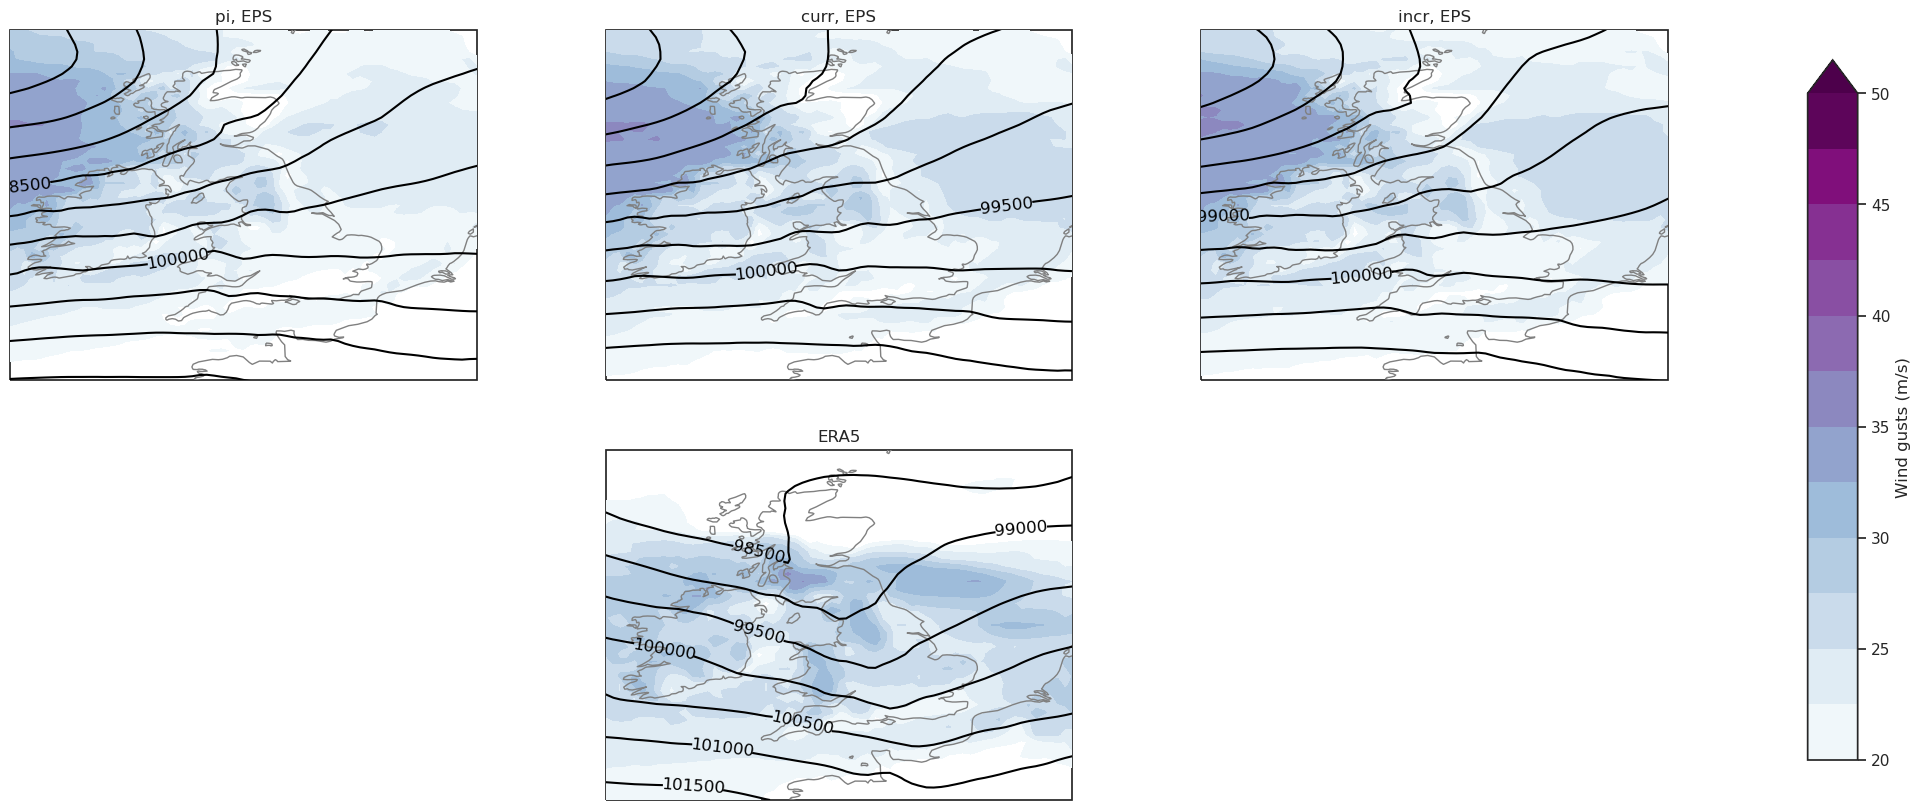

In [ ]:
uk = [-11, 5, 48, 60]

fig = plt.figure(1, figsize=(25, 10))
clevs_fg10 = np.linspace(20, 40, 11)  # 17
clevs_msl = np.linspace(95000,105000,21)
projection = ccrs.PlateCarree()

#subplot of pi
ax_pi = plt.subplot(2,3,1,projection = projection)
ax_pi.set_extent(uk, projection)
ax_pi.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)




cf = ax_pi.contourf(lon, lat, wd_pi, clevs_fg10, cmap=plt.cm.BuPu,
                transform=projection, zorder = 10, extend = 'max')
cs = ax_pi.contour(lon,lat, p_pi, clevs_msl, colors='black',
                    transform=projection, zorder = 16)
plt.clabel(cs, fmt='%d')
ax_pi.set_title('pi'+", EPS")

#subplot of curr
ax_curr = plt.subplot(2,3,2,projection = projection)
ax_curr.set_extent(uk, projection)
ax_curr.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)


cf = ax_curr.contourf(lon, lat, wd_curr,clevs_fg10, cmap=plt.cm.BuPu,
                transform=projection, zorder = 10, extend = 'max')
cs = ax_curr.contour(lon,lat, p_curr, clevs_msl,colors='black',
                    transform=projection, zorder = 16)
plt.clabel(cs, fmt='%d')
ax_curr.set_title('curr'+", EPS")

#subplot of incr
ax_incr = plt.subplot(2,3,3,projection = projection)
ax_incr.set_extent(uk, projection)
ax_incr.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)

cf = ax_incr.contourf(lon, lat, wd_incr, clevs_fg10, cmap=plt.cm.BuPu,
                transform=projection, zorder = 10, extend = 'max')
cs = ax_incr.contour(lon,lat, p_incr, clevs_msl, colors='black',
                    transform=projection, zorder = 16)
plt.clabel(cs, fmt='%d')
ax_incr.set_title('incr'+", EPS")

#subplot of era5
ax_era5 = plt.subplot(2,3,5,projection = projection)
ax_era5.set_extent(uk, projection)
ax_era5.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)

cf = ax_era5.contourf(lon_e, lat_e, era5_GUST.sel(time='2022-02-16'), clevs_fg10, cmap=plt.cm.BuPu,
                transform=projection, zorder = 10, extend = 'max')
cs = ax_era5.contour(lon_e,lat_e, era5_MSL,clevs_msl, colors='black',
                    transform=projection, zorder = 16)
plt.clabel(cs, fmt='%d')
ax_era5.set_title('ERA5')


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(cf, cax=cbar_ax, label='Wind gusts (m/s)', extend = 'max')

plt.savefig('figures/00_wind_gusts_inidate'+'2022-02-14'+'.png')
plt.savefig('figures/00_wind_gusts_inidate'+'2022-02-14'+'.png')


In [ ]:
'''
#subplot of era5

ax_era5 = plt.subplot(2,3,5,projection = projection)
ax_era5.set_extent(uk, projection)
ax_era5.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
ax_era5.add_feature(cfeature.OCEAN, zorder=12, color = 'white')  #zorder > 10

cf = ax_era5.contourf(lon_e, lat_e, era5_GUST.sel(time='2022-02-14'), cmap=plt.cm.BuPu,
                transform=projection, zorder = 10, extend = 'max')
ax_era5.set_title('ERA5')
'''

"\n#subplot of era5\n\nax_era5 = plt.subplot(2,3,5,projection = projection)\nax_era5.set_extent(uk, projection)\nax_era5.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)\nax_era5.add_feature(cfeature.OCEAN, zorder=12, color = 'white')  #zorder > 10\n\ncf = ax_era5.contourf(lon_e, lat_e, era5_GUST.sel(time='2022-02-14'), cmap=plt.cm.BuPu,\n                transform=projection, zorder = 10, extend = 'max')\nax_era5.set_title('ERA5')\n"